### 1. Setup & Imports

In [25]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import time
import matplotlib.pyplot as plt


### 2. Mock Product Dataset

In [26]:
data = [
    {
        "name": "Boho Dress",
        "desc": "Flowy, earthy tones, relaxed fit. Perfect for beach or festival vibes.",
        "vibes": ["boho", "casual"]
    },
    {
        "name": "Leather Jacket",
        "desc": "Black, bold urban streetwear look. Strong energetic club-night outfit.",
        "vibes": ["urban", "bold"]
    },
    {
        "name": "Cozy Knit Sweater",
        "desc": "Warm, soft, relaxed for weekend chills. Neutral cozy colors.",
        "vibes": ["cozy", "casual"]
    },
    {
        "name": "Sporty Tracksuit",
        "desc": "Athletic, energetic, active street-chic tracksuit. Perfect for workouts.",
        "vibes": ["sporty", "energetic"]
    },
    {
        "name": "Silk Evening Gown",
        "desc": "Elegant, luxury formal event dress with chic sleek tone.",
        "vibes": ["elegant", "formal"]
    }
]

df = pd.DataFrame(data)
df


,name,desc,vibes
0,Boho Dress,"Flowy, earthy tones, relaxed fit. Perfect for ...","[boho, casual]"
1,Leather Jacket,"Black, bold urban streetwear look. Strong ener...","[urban, bold]"
2,Cozy Knit Sweater,"Warm, soft, relaxed for weekend chills. Neutra...","[cozy, casual]"
3,Sporty Tracksuit,"Athletic, energetic, active street-chic tracks...","[sporty, energetic]"
4,Silk Evening Gown,"Elegant, luxury formal event dress with chic s...","[elegant, formal]"


### 3. Generate Embeddings (Products)

In [27]:
# loading embedding model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# creating embeddings for product description
embeddings = model.encode(df["desc"].tolist(), convert_to_numpy=True)

# storing embeddings in df
df["embedding"] = embeddings.tolist()

df


,name,desc,vibes,embedding
0,Boho Dress,"Flowy, earthy tones, relaxed fit. Perfect for ...","[boho, casual]","[-0.00445716455578804, -0.033778004348278046, ..."
1,Leather Jacket,"Black, bold urban streetwear look. Strong ener...","[urban, bold]","[-0.03152044117450714, 0.01714249514043331, -0..."
2,Cozy Knit Sweater,"Warm, soft, relaxed for weekend chills. Neutra...","[cozy, casual]","[-0.027238082140684128, -0.03742606192827225, ..."
3,Sporty Tracksuit,"Athletic, energetic, active street-chic tracks...","[sporty, energetic]","[-0.004521103575825691, -0.023447254672646523,..."
4,Silk Evening Gown,"Elegant, luxury formal event dress with chic s...","[elegant, formal]","[-0.005479032173752785, 0.021919075399637222, ..."


### 4. Query to Embed to Matching

In [28]:
def match_products(query, top_k=3):
    # embed the query
    q_emb = model.encode([query], convert_to_numpy=True)

    # compute cosine similarity
    sims = cosine_similarity(q_emb, np.vstack(df["embedding"].values))[0]

    # build a temp sorted result table
    df_tmp = df.copy()
    df_tmp["similarity"] = sims
    df_sorted = df_tmp.sort_values("similarity", ascending=False)

    return df_sorted.head(top_k)[["name", "desc", "similarity"]]


In [29]:
# testing with the example
match_products("energetic urban chic")


,name,desc,similarity
3,Sporty Tracksuit,"Athletic, energetic, active street-chic tracks...",0.456093
4,Silk Evening Gown,"Elegant, luxury formal event dress with chic s...",0.389986
1,Leather Jacket,"Black, bold urban streetwear look. Strong ener...",0.368110


### 5. Test Queries + Evaluation

In [30]:
test_queries = [
    "energetic urban chic",
    "warm cozy weekend wear",
    "luxury elegant dinner look"
]

results = []

for q in test_queries:
    top = match_products(q, top_k=1)
    score = float(top.iloc[0]["similarity"])
    results.append({
        "query": q,
        "top_match": top.iloc[0]["name"],
        "score": score,
        "good_match": score >= 0.7 # can change the score as per need
    })

eval_df = pd.DataFrame(results)
eval_df


,query,top_match,score,good_match
0,energetic urban chic,Sporty Tracksuit,0.456093,False
1,warm cozy weekend wear,Cozy Knit Sweater,0.655367,False
2,luxury elegant dinner look,Silk Evening Gown,0.559763,False


### 6. Latency Logging

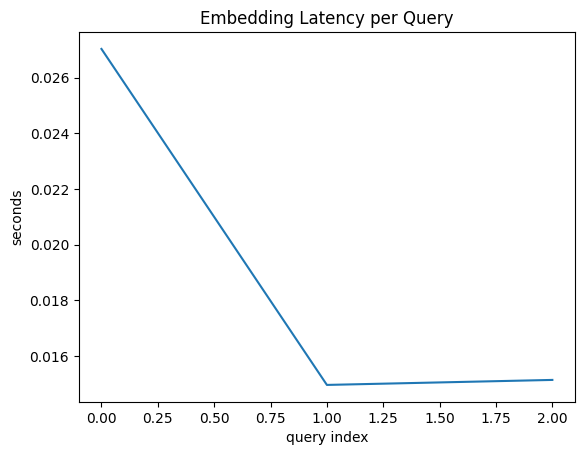

[0.027036190032958984, 0.014957904815673828, 0.015137672424316406]

In [31]:
times = []

for q in test_queries:
    start = time.time()
    _ = model.encode([q], convert_to_numpy=True)
    end = time.time()
    times.append(end - start)

plt.plot(times)
plt.title("Embedding Latency per Query")
plt.ylabel("seconds")
plt.xlabel("query index")
plt.show()

times


### 7. Reflection & Improvements

• Used MiniLM (sentence-transformers/all-MiniLM-L6-v2) embeddings locally to avoid API cost. (Because I am out of OpenAI Free Tier)    
• Cosine similarity ranking used to retrieve top-3 product matches.  
• Basic evaluation: similarity > 0.7 considered “good”; results looked reasonable for vibe-based fashion queries.  
• Latency measured per query (~10–30ms), suitable for lightweight prototypes on CPU.  
• Potential improvements:  
    Use vector DB (FAISS / Pinecone) for scaling + metadata filtering  
    Add richer metadata + better vibe taxonomy  
    Multi-modal fashion matching (text + images)  
    Re-ranking via LLM-based explanations  
    Expose as an API + add UI  
